# Investigating one ship case

### run DataCleaning-final.ipynb first

In [53]:
import numpy as np
import pandas as pd
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

from os import path, getcwd
from glob import glob
import pykalman
import datetime as dt

In [54]:
delta_cur = pd.read_csv("delta_processed.csv",sep='\t',parse_dates=['ReceivedTime'])

In [55]:
user_ID_allowed = np.unique(delta_cur['UserID'])
# As the first try, we choose one ship only
UserID = list(user_ID_allowed)[1]
UserID

211377300

In [56]:
df = delta_cur[delta_cur['UserID']==UserID] #select the single ship
df = df.drop(['UserID','Unnamed: 0'],axis=1)
df = df.sort_values(by=['Time2']).reset_index(drop=True) #sort entries by Time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Data columns (total 7 columns):
ROT             1982 non-null float64
SOG             1982 non-null float64
Longitude       1982 non-null float64
Latitude        1982 non-null float64
TrueHeading     1982 non-null float64
ReceivedTime    1982 non-null datetime64[ns]
Time2           1982 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 108.5 KB


In [57]:
del delta_cur
df.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,ReceivedTime,Time2
0,0.0,20.3,-123.19649,48.18748,248.0,2013-10-25 11:52:00.693,1382702040
1,0.0,20.2,-123.19870,48.18689,248.0,2013-10-25 11:52:19.743,1382702040
2,0.0,20.9,-123.18581,48.40534,47.0,2013-10-29 01:28:30.580,1383010200
3,0.0,20.6,-123.18251,48.40707,42.0,2013-10-29 01:28:59.830,1383010200
4,0.0,20.8,-123.18113,48.40791,41.0,2013-10-29 01:29:12.767,1383010200


In [58]:
# figure out if the ship leaves the Metro Vancouver
time_diff = np.diff(df['Time2']) #the time between subsequent signals
dfs =[] #here we store dataframe each of them is a part of unique path
idx = 0
#invesgate all cases where the ship was not tracked for an hour or more.
#If ship is near the edge of Metro Vancouver, split path into two parts
#-- we assume that it leaves the Metro Vancouver Area
for i in range(len(time_diff)):
    if time_diff[i]>3600: #1 hour = 60*60=3600 seconds
        #investigate where the ship is located
        lat = df.loc[i,'Latitude']
        lon = df.loc[i,'Longitude']
        #recall original filtering
        #mask = (delta_cur['Longitude']>-127)&(delta_cur['Longitude']<-120)
        #mask = mask & (delta_cur['Latitude']>48)|(delta_cur['Latitude']<50)
        if (lat>-126.8)&(lat<-119.8)&(lon>48.2)&(lon<49.8):
            #the ship is inside Metro Vancouver
            continue
        else:
            dfs.append(df.iloc[idx:i])
            idx = i+1
            
dfs.append(df.loc[idx:])  #append whatever chunk contains the last row          

In [59]:
#how many different paths we got
len(dfs)

2

In [60]:
df = dfs[0] # for now, approximate the one path
df1 = dfs[1]

In [61]:
#group by time (timedelta = 6 seconds) and compute mean location, ROT, SOG and TrueHeading
def compute_mean(df_t):
    rot =  np.mean(df_t['ROT'])
    sog = np.mean(df_t['SOG'])
    lat = np.mean(df_t['Longitude'])
    lon = np.mean(df_t['Latitude'])
    truehed = np.mean(df_t['TrueHeading'])
    time2 = df_t['Time2'].iloc[0]
    return [rot,sog,lon,lat,truehed,time2]

def process_df(df):
    col_names = df.columns.values.tolist()
    col_names.remove('ReceivedTime')
    df_new = pd.DataFrame(columns = col_names)
    idx = 0 #next index in df_new to be written at
    min_time = np.min(df['Time2'])
    max_time = np.max(df['Time2'])
    for t in range(min_time,max_time+360,360):
        mask = (df['Time2'] == t)
        if np.sum(mask)>0.5: #there is at least one entry
            df_new.loc[idx] = compute_mean(df[mask])
        else:
            df_new.loc[idx] = np.nan
        idx = idx + 1
    return df_new

In [62]:
#process each dataframe in dfs
dfs_new = []
for i in range(len(dfs)):
    dfs_new.append(process_df(dfs[i]))
#The data is ready for approximating paths

In [63]:
df_new = dfs_new[1]
df_new.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,Time2
0,0.0,20.766667,48.406773,-123.183150,43.333333,1.383010e+09
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,20.200000,48.486680,-123.162270,345.000000,1.383011e+09
3,0.0,19.900000,48.496690,-123.166390,345.000000,1.383011e+09
4,0.0,20.046154,48.535350,-123.184956,340.076923,1.383012e+09


In [64]:
#to feed the data to pykalman we need to mask NaN values
mask = df_new[['Latitude','Longitude']].isnull()
measurements = np.ma.array(np.array(df_new[['Latitude','Longitude']]),mask=mask)
print(measurements[:5,:])

[[-123.18315 48.40677333333334]
 [-- --]
 [-123.16227 48.48668]
 [-123.16639 48.49669]
 [-123.18495615384614 48.53535]]


In [65]:
from pykalman import KalmanFilter
transition_matrix = np.eye(4)
transition_matrix[0,1]=1
transition_matrix[2,3]=1 #[[1, 1], [0, 1]]
print('Transition matrix')
print(transition_matrix)
observation_matrix= np.zeros((2,4))
observation_matrix[0,0]=1
observation_matrix[1,2]=1
print('Observation matrix')
print(observation_matrix)
initial_state = (df_new.loc[0,'Latitude'],0,df_new.loc[0,'Longitude'],0)
kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean=initial_state)

kf = kf.em(measurements, n_iter=5)

(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

Transition matrix
[[ 1.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  0.  1.]]
Observation matrix
[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]]


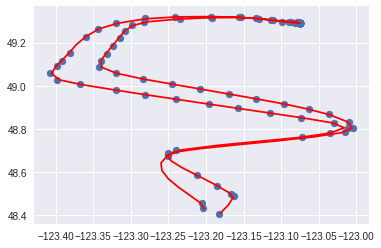

In [66]:
view = df_new[['Latitude','Longitude']].dropna(axis=0)
plt.plot()
plt.scatter(view['Latitude'],view['Longitude'])
plt.plot(smoothed_state_means[:,0],smoothed_state_means[:,2],color='red')

# Trying to write Kalman filter from scratch (raw and may be not working)

In [41]:
#uses the code from https://stackoverflow.com/questions/13901997/kalman-2d-filter-in-python
def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0. 0. 0.').T,
              Q = np.matrix(np.eye(4))):
    """
    Parameters:    
    x: initial state 4-tuple of location and velocity: (x0, x1, x0_dot, x1_dot)
    P: initial uncertainty convariance matrix
    measurement: observed position
    R: measurement noise 
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    """
    return kalman(x, P, measurement, R, motion, Q,
                  F = np.matrix('''
                      1. 0. 1. 0.;
                      0. 1. 0. 1.;
                      0. 0. 1. 0.;
                      0. 0. 0. 1.
                      '''),
                  H = np.matrix('''
                      1. 0. 0. 0.;
                      0. 1. 0. 0.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty convariance matrix
    measurement: observed position (same shape as H*x)
    R: measurement noise (same shape as H)
    motion: external motion added to state vector x
    Q: motion noise (same shape as P)
    F: next state function: x_prime = F*x
    H: measurement function: position = H*x

    Return: the updated and predicted new values for (x, P)

    See also http://en.wikipedia.org/wiki/Kalman_filter

    This version of kalman can be applied to many different situations by
    appropriately defining F and H 
    '''
    # UPDATE x, P based on measurement m
    if not np.any(np.ma.getmask(measurement)):        
        # distance between measured and current position-belief
        y = np.matrix(measurement).T - H * x
        #print(timed)
        S = H * P * H.T + R  # residual convariance
        K = P * H.T * S.I    # Kalman gain
        x = x + K*y
        I = np.matrix(np.eye(F.shape[0])) # identity matrix
        P = (I - K*H)*P
    else:
        K = np.zeros(K.shape)
    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q

    return x, P

In [ ]:
H= np.matrix([[1., 0., 0., 0.],[0., 1., 0., 0.]])
print(H)

In [ ]:
def kalman_wiki(x, P, measurement, R=None, Q=None, F=None,
                H= np.matrix([[1., 0., 0., 0.],[0., 1., 0., 0.]])):
    """
    General model:
    x_new = Fx+noise1
    x1_new = Hx_new +noise2,
    where noise1 is Gaussian with mean 0 and covariance matrix S
    and noise 2 is Gaussian with mean 0 and covariance matrix P
    
    Variables:
    x: estimated current kinematic vector (position+velocity+acceleration)
    x1: observed part of kinematic vector
    H: measurement matix, specifies which entries of kinematic vector are observed.
        Hopefully, x1~H@x
    P: estimated error covariance
    Q: covariance matrix of the process noise
    
    """
    if R is None:
        R=0.2*np.eye(len(measurement))
    if Q is None:
        Q=np.zeros(P.shape)
    if F is None:
        F = np.eye(x.shape[0])
        F[0,2] = 1 #impact of velocity to x-position
        F[1,3] = 1 #impact of velocity to y-position
    
    x1 = np.transpose(np.matrix(measurement))
    #pre-fitting prediction
    y = x1 - H@x #measurement pre-fit residual (estimated mean)
    S = R + H@P@np.transpose(H) #measurenet pre-fit covariance (estimated covariance)
    K = P@np.transpose(H)@np.linalg.inv(S) #Kalman gain
    
    #predict
    x = F@x #new state estimate
    P = F@P@np.transpose(F) + Q #new covariance estimate
    
    #update predictions based on pre-fitting info
    x = x + K@y
    #dummy_var = np.eye(K.shape[0]) - K@H    
    #P = dummy_var@P@np.transpose(dummy_var) + K@R@np.transpose(K)
    P = (np.eye(H.shape[1]) - K@H)@P
    y = x1 - H@x
    return x,P
   

In [ ]:
true_x = np.linspace(1,4,num=100)
true_y = [x**2 for x in true_x]
plt.plot(true_x,true_y)

x1 = np.linspace(1,4,num=10)
y1 = [x**2 for x in x1]
observed_x = x1 + 0.2*np.random.randn(10)
observed_y = y1+ 0.2*np.random.randn(10)
measurements = [[observed_x[i],observed_y[i]] for i in range(len(observed_x))]
plt.scatter(observed_x,observed_y,color='r')
#print(measurements)

results =[]
x = np.transpose(np.matrix([1,0,1,0])) #initial point
P = np.eye(4)
for meas in measurements:#,time_diff):
    x, P = kalman_wiki(x, P, meas)
    #print(x)
    results.append(np.array(np.transpose(x))[0])
kalman_x, kalman_y,vel_x,vel_y = zip(*results)
print(results[-1:])
plt.plot(kalman_x, kalman_y, color='g')
plt.show()

# Implementing the Kalman filter by myself (row code)

In [ ]:
#plain kalman filter based on averaged samples only
#set up initial conditions
from numpy import ma
x = np.matrix('0. 0. 0. 0.').T #location
P = np.matrix(np.eye(4))*1000 # initial uncertainty

result = []
R = 0.01**2
n_rows = np.sum(mask)
observed_x = np.array(df_new['Latitude'])
observed_y = np.array(df_new['Longitude'])
#find missing values
mask = df_new['ROT'].isnull()
observed_x = ma.masked_array(observed_x, mask)
observed_y = ma.masked_array(observed_y, mask)
plt.plot(observed_x, observed_y, 'ro')
#time_diff = np.zeros(n_rows)
#time_diff[1:] = np.diff(df.loc[mask,'ReceivedTime'].apply(lambda x: x.timestamp()))
for meas in zip(observed_x,observed_y):#,time_diff):
    x, P = kalman_xy(x, P, meas, R)
    result.append((x[:2]).tolist())
kalman_x, kalman_y = zip(*result)
plt.plot(kalman_x, kalman_y, 'g-')
plt.show()

In [ ]:
#let's add velocity to the model